# Reference implementation  of GW 

The purpose of this notebook is two-fold. First, it is meant to give an outline of the working equations and implementation of the simplest approximation within GW family, i.e. $G_0W_0$@HF/DFT, and some of its extensions. Second, it provides a playground for testing new reduced-cost GW algorithms such as SPA or optimized virtual space approach of Bruneval et al. The theory and algorithms behind the code can be found in the papers:

1. Bruneval, F., Rangel, T., Hamed, S. M., Shao, M., Yang, C., & Neaton, J. B. (2016). molgw 1: Many-body perturbation theory software for atoms, molecules, and clusters. Computer Physics Communications, 208, 149–161. https://doi.org/10.1016/J.CPC.2016.06.019

2. van Setten, M. J., Weigend, F., & Evers, F. (2013). The GW -Method for Quantum Chemistry Applications: Theory and Implementation. Journal of Chemical Theory and Computation, 9(1), 232–246. https://doi.org/10.1021/ct300648t

3. Bruneval, F. (2012). Ionization energy of atoms obtained from GW self-energy or from random phase approximation total energies. The Journal of Chemical Physics, 136(19), 194107. https://doi.org/10.1063/1.4718428

4. Dreuw, A., Head-Gordon, M. (2005). Single-Reference ab Initio Methods for the Calculation of Excited States of Large Molecules. https://doi.org/10.1021/CR0505627

## Working equations of GW method

GW approximation can be derived from Hedin equations by substituting vertex function $\Gamma$ for the product of the two delta functions $\Gamma = \delta(1-2) \delta(2-3)$ (i stands for a combined coordinate $(r_i, t_i)$. Upon substitution Hedin equations assume the followign form:

$$
G(1,2) = G_H(1,2) + \int d(34) G_H(1,3) \Sigma(3,4) G(4,2) \\
\Sigma(1,2) = i G(1, 2^{+}) W(1, 2)\\
W(1,2) = v(1,2) + \int d(34) v(1,3) P(3,4) W(4,2)\\
P(1,2) = -i G(1,2) G(2,1^{+})
$$

"+" indicates choronological ordering (e.g. $t_1^{+} = t_1 + \eta$, $\eta \to 0$).
Screened Coulomb interaction W(1,2) can be expressed in terms of the full density response function $\chi$:

$$
W(1,2) = v(1,2) + \int d(34) v(1,3) \chi(3,4) v(4,2)
$$

Note that (unscreened) Coulomb interaction is assumed to be instanteneous, i.e. $v(1,2) = \delta(t_1 - t_2) 1/|r_1 - r_2|$ (shorthand notation: $ v(r_1,r_2)\delta(t_1 - t_2)$), therefore, the last equation can be written explicitly in terms of the integrals over spatial coordinates only:

$$
W(1,2) = v(r_1,r_2)\delta(t_1 - t_2)  + \int d(r_3r_4) v(r_1,r_3) \chi(r_3,r_4; t_1 - t_2) v(r_4,r_2)
$$

In frequency domain the equation for the self-energy is transfomed as follows (note the error in [2]):

$$
\Sigma(r_1,r_2, \omega) = \frac{i}{2\pi} \int_{-\infty}^{+\infty} e^{i\xi \eta} G(r_1, r_2, \omega + \xi) W(r_1, r_2, \xi) d\xi,
$$
where $\eta \to 0+$. Combining previous equation with the expression for screened Coulomb interaction one obtains:

$$
\Sigma(r_1,r_2, \omega) = \frac{i}{2\pi} v(r_1, r_2) \int_{-\infty}^{+\infty} e^{i\xi \eta} G(r_1, r_2, \omega + \xi) d\xi +  \frac{i}{2\pi} \int_{-\infty}^{+\infty} d \xi \int d(r_3r_4) e^{i\xi \eta} G(r_1, r_2, \omega + \xi) v(r_1,r_3) \chi(r_3,r_4; \xi) v(r_4,r_2) 
$$

The first contribution can be readily recognized as an **exchange** part of the self-energy as $-\rho(r_1, r_2) = \frac{i}{2\pi} \int_{-\infty}^{+\infty} e^{i\xi \eta} G(r_1, r_2, \xi) d\xi$ is one particle density matrix. The remaining part is due to correlation. Diagrammatically, the last equation is represented as:

![Diagrammatic representation of self-energy in GW](hedin_diag.png)

Full density response is calculated at RPA/TDDFT level by solving Casida equation:

$$ \begin{bmatrix}A & B\\-B & -A\end{bmatrix} \begin{bmatrix}X_s\\Y_s\end{bmatrix} = \omega_s \begin{bmatrix}X_s\\Y_s\end{bmatrix}, $$

where (for spin-resticted case) $A_{ia, jb} = \delta_{ij} \delta_{ab} (\epsilon_a - \epsilon_i) + (ia|jb) - c_{HF} (ij|ab) + (1-c_{HF})(ia|f_{xc}|jb)$ and $B_{ia, jb} = (ia|bj) - c_{HF} (ib|aj) + (1-c_{HF})(ia|f_{xc}|bj)$. Once all the solutions of Casida equation are found (see below for more detail), the matrix elements of W can be expressed as follows:

$$
W_{mn\sigma_1, op\sigma_2} = (mn\sigma_1|op\sigma_2) + \sum_s \omega_{mn\sigma_1}^{s}\omega_{op\sigma_2}^{s} \times \big( \frac{1}{\omega - \Omega_s + i\eta} -  \frac{1}{\omega + \Omega_s - i\eta} \big), 
$$

where $\omega_{mn\sigma_1}^{s} = \sum_{ia\sigma}(mn\sigma_1|ia\sigma)(X_{ia\sigma}^{s} + Y_{ia\sigma}^{s})$. The product basis representation of screened Coulomb interaction is then contracted with zero-order Kohn-Sham one-particle Green's function to give self-energy (as shown above):

$$
G_{\sigma\sigma\prime}^{KS}(r_1, r_2, \omega) = \delta_{\sigma\sigma\prime} \sum_k \frac{\phi_{k\sigma}(r_1)\phi_{k\sigma}^{*}(r_2) }{\omega - \epsilon_{k\sigma} + i\eta \times sign(\epsilon_{k\sigma} - \mu)}
$$



The integrals over $\xi$ can be performed analytically (the integration contour is closed in the upper half-plane):

$$
\int_{-\infty}^{+\infty} \frac{d\xi e^{i\xi \eta}}{(\xi + \omega - \epsilon_{k\sigma} + i\eta \times sign(\epsilon_{k\sigma} - \mu))(\xi - \Omega_s + i\eta)} = \begin{cases} 0 &\mbox{if } \epsilon_{k\sigma} > \mu\\
-\frac{2\pi i}{\omega - \epsilon_{k\sigma} + \Omega_s - 2i\eta} &\mbox{otherwise }\end{cases}
$$

$$
\int_{-\infty}^{+\infty} \frac{d\xi e^{i\xi \eta}}{(\xi + \omega - \epsilon_{k\sigma} + i\eta \times sign(\epsilon_{k\sigma} - \mu))(\xi + \Omega_s - i\eta)} = \begin{cases} \frac{2\pi i}{\omega - \epsilon_{k\sigma} - \Omega_s + 2i\eta} &\mbox{if } \epsilon_{k\sigma} > \mu\\
0 &\mbox{otherwise }\end{cases}
$$

The GW self-energy can, therefore, be written in terms of tensor contractions:

$$
\Sigma_{nn\sigma}(\omega) = \frac{i}{2\pi} \int_{-\infty}^{+\infty} d \xi e^{i\xi \eta} \Sigma_i \frac{W_{ni\sigma, in\sigma}(\xi)}{\xi + \omega - \epsilon_{i\sigma} - i\eta} + \Sigma_a \frac{W_{na\sigma, an\sigma}(\xi)}{\xi + \omega - \epsilon_{a\sigma} + i\eta}\\
=-\Sigma_i (ni\sigma|in\sigma) + \Sigma_{is} \frac{\omega_{ni\sigma}^s\omega_{in\sigma}^s}{\omega - \epsilon_{i\sigma} + \Omega_s - 2i\eta} + \Sigma_{as} \frac{\omega_{na\sigma}^s\omega_{an\sigma}^s}{\omega - \epsilon_{a\sigma} - \Omega_s + 2i\eta}
$$


If one takes into account that $G^{KS-1} = G^{H-1} + V_{xc}$, diagonal approximation for the inverse Dyson equation assumes the following form:

$$
\omega = \epsilon_{n\sigma} - \langle n\sigma | V_{xc}^{\sigma} | n\sigma \rangle + \Sigma_{nn\sigma}^{xc}(\omega)
$$

In [2]:
import psi4
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Set up the test molecule & the basis set

#h2o = psi4.geometry("""O   0.0000000 0.0000000 -0.0644484
#                       H   0.7499149 0.0000000 0.5114912
#                       H  -0.7499149 0.0000000 0.5114912
#                       symmetry c1
#""")

h2o = psi4.geometry("""O   0.000000000000  -0.143225816552   0.000000000000 
                       H   1.638036840407   1.136548822547  -0.000000000000
                       H  -1.638036840407   1.136548822547  -0.000000000000
                       symmetry c1
                       units bohr
""")

# Set SCF options (convergence criteria for the density matrix and energy) and basis set 

psi4.set_options({'basis' : 'sto-3g', 'd_convergence' : 1e-7, 'e_convergence' : 1e-9 })

# run scf

psi4.set_output_file('h2o_sto.out')

# Obtain converged energy and WaveFunction object

en, wfn = psi4.energy('hf', molecule=h2o, return_wfn=True)
print("SCF energy is %16.10f" % en)

# Make sure that we are using pure aungular momentum functions (same as MolGW)

assert wfn.basisset().has_puream()

SCF energy is   -74.9421761261


For closed shell reference (i.e., alpha and beta orbitals are the same) A, B matrices will have the block structure shown below:

$$
 \begin{bmatrix}C^{\alpha\alpha} & C^{\alpha\beta}\\C^{\beta\alpha} & C^{\beta\beta}\end{bmatrix},
$$

where $C^{\alpha\alpha} = C^{\beta\beta}$ and $C^{\alpha\beta} = C^{\beta\alpha}$. The symmetry relations between the blocks can be utilized to further simplify the RPA eigenvalue problem by applying the unitary transformation $\mathbf{U}$ which decouples singlet and triplet excitations:

$$
\mathbf{U} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 & 0 & 0\\ 1 & -1 & 0 & 0 \\ 0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1 \end{bmatrix} 
$$

$$ \begin{bmatrix}A^{+} & 0 & B^{+} & 0\\0 & A^{-} & 0 & B^{-} \\ -B^{+} & 0 & -A^{+} & 0 \\ 0 & -B^{-} & 0 & -A^{-}\end{bmatrix} \begin{bmatrix}X^{+}_s\\ X^{-}_s \\Y^{+}_s\\ Y^{-}_s \end{bmatrix} = \omega_s \begin{bmatrix}X^{+}_s\\ X^{-}_s \\Y^{+}_s\\ Y^{-}_s \end{bmatrix}, $$

where $A^{\pm} = A^{ss} \pm A^{os}$ and $B^{\pm} =  B^{ss} \pm B^{os}$. "ss" and "os" stand for "same spin" and "opposite spin", respectively. Explicit expressions for the matrix elements from the definitions of A, B matrices:

$$
A_{ia, jb}^{+} = \delta_{ij} \delta_{ab} (\epsilon_a - \epsilon_i) + 2(ia|jb) - c_{HF} (ij|ab) + (1-c_{HF})(ia|f_{xc}^{\alpha\alpha} + f_{xc}^{\alpha\beta}|jb)\\
B_{ia, jb}^{+} = 2(ia|bj) - c_{HF} (ib|aj) + (1-c_{HF})(ia|f_{xc}^{\alpha\alpha} + f_{xc}^{\alpha\beta}|bj)\\
A_{ia, jb}^{-} = \delta_{ij} \delta_{ab} (\epsilon_a - \epsilon_i) -c_{HF} (ij|ab) + (1-c_{HF})(ia|f_{xc}^{\alpha\alpha} - f_{xc}^{\alpha\beta}|jb)\\
B_{ia, jb}^{-} = -c_{HF} (ib|aj) + (1-c_{HF})(ia|f_{xc}^{\alpha\alpha} - f_{xc}^{\alpha\beta}|bj)
$$

The eigenvectors of the original eigenvalue problem are modified: $V^{\pm}_s = \frac{1}{\sqrt{2}}(V^{\alpha}_s \pm V^{\beta}_s)$. The block structure of the eigenvalue problem allows solving for "+" and "-" components of the eigenvectors separately. Moreover, since we are interested in $X^{+} + Y^{+}$ (they are required to construct $\omega$ tensors, see above) we can solve the "+" eigenvalue problem only. 
For simplicity current implementation uses HF reference ($c_{HF} = 1$); that is supposed to produce RPA/TDHF screening, however, Bruneval's implementation of RPA screening discards exchange contributions to A and B matrices. In order to facilitate comparison we will follow the same approach here. 


In [4]:
from numpy import linalg as LA

In [5]:
# Extract HF data from Psi4 

# Orbital coefficients 

C = wfn.Ca()
Co = wfn.Ca_subset("AO", "OCC")
Cv = wfn.Ca_subset("AO", "VIR")
epsilon = np.asarray(wfn.epsilon_a())

print("Orbital energies", epsilon)

# Information about orbital spaces

nbf = wfn.nmo()
nocc = wfn.nalpha()
nvir = nbf - nocc

# Transform ERI-s
# Get the integrals from mints helper
# Form oNNN MO tensor, oN^4 cost

mints = psi4.core.MintsHelper(wfn.basisset())
MO = np.asarray(mints.mo_eri(Co, C, C, C))


Orbital energies [-20.26313119  -1.20972369  -0.54797111  -0.43653438  -0.38759806
   0.47761482   0.58814715]


In [6]:
# Calculate A^{+} + B^{+} matrix; Note that A^{+} - B^{+} will be diagonal so we could store just a
# flattened 1D array

# Diagonal \epsilon_a - \epsilon_i
eps_diag = epsilon[nocc:].reshape(-1, 1) - epsilon[:nocc]
assert eps_diag.shape == (nvir, nocc)

# A^{+} + B^{+}
ApB = np.einsum("ij,ab,ai -> iajb", np.eye(nocc), np.eye(nvir), eps_diag) + 4. * MO[:nocc, nocc:, :nocc, nocc: ]
ApB = ApB.reshape((nocc*nvir, nocc*nvir)) 
# since nD numpy arrays have C-style memroy layout the occupied orbital inedex changes slower than the virtual one

# Diagonal of  A^{+} - B^{+}
AmB_diag = eps_diag.T.reshape((1, -1))
AmB_diag = np.diag(AmB_diag[0,:])

assert AmB_diag.shape == ApB.shape


# Form C matrix (as one usually does when solving RPA eigenvalue problem)
C = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), ApB, np.sqrt(AmB_diag))

# Solve for the excitation energies and calculate X + Y eigenvectors

omega2, Z = LA.eigh(C)
omega = np.sqrt(omega2)
xpy = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), Z, np.diag(1./np.sqrt(omega)))

print(omega)
print("xpy components")

for i in range(len(omega)):
    print(xpy[:,i])

[ 0.93185397  1.00551887  1.0246072   1.05605733  1.2533905   1.42618979
  1.9090891   1.93222014 20.79307735 20.89030158]
xpy components
[ 5.00852937e-18  2.01710603e-17  9.83252384e-16 -1.85924539e-15
 -3.29720369e-15  4.47445404e-15 -7.86705229e-15  8.20483187e-15
 -9.63579517e-01 -5.56187155e-13]
[ 2.43593114e-05  1.57753699e-14  7.48873315e-02 -1.22444732e-12
  8.04698268e-12  3.78626047e-01  8.89238062e-01  2.19341422e-12
 -5.49333068e-15 -6.49082571e-14]
[ 8.38644529e-18 -4.24555334e-17  6.07708449e-15  1.99010982e-15
 -1.19689342e-14  3.57492160e-14  5.42098408e-14  4.57222600e-15
 -4.99472575e-13  9.75864486e-01]
[-7.87832963e-15 -1.58436963e-03  1.40589105e-12  9.06285941e-02
 -6.86150775e-01  6.72989402e-12  4.77674574e-12 -7.03719125e-01
 -3.16725157e-15 -4.96777906e-15]
[-1.03236668e-14 -1.09358322e-03 -5.43950296e-13 -2.91688097e-02
  6.46537446e-01 -1.37420892e-12 -3.34907321e-12 -6.31981598e-01
 -6.38233658e-15  1.03963252e-14]
[ 1.60060904e-03 -8.49019972e-15  3.281721

The values should be compared to those produced by **MolGW** code for the same geometry & basis:

0.93184532974707635        
1.0055084957782070        
1.0245854271826726        
1.0560497534213935        
1.2533735998089335         
1.4261666879014583        
1.9090696520971144        
1.9321796168357281        
20.792841443403219         
20.890052672176569

The corresponding eigenvectors are shown below in the same order:

```
  6.9863451824159508E-020   1.0347903982226666E-018  -2.9025622470217256E-016   1.0380723585650678E-016   2.7263929234128543E-016  -1.1782370664958697E-015  -2.1498300574174335E-015   6.0057889311452796E-016 -0.96357983850259821       -3.7314048283888026E-015
  
  -2.4261027736339349E-005  -7.1095753105462959E-017   7.4894099673548015E-002  -4.9467843830327603E-015   3.4687286906195304E-014  0.37861147419427094      -0.88924558697934708       -1.5849462091845140E-014   1.5136339234680844E-015   4.1910119296874737E-015
  
   6.5175773962394187E-019  -1.0614634197634954E-017  -3.6213382540575118E-016  -5.2790639681214681E-016   3.7595512502261316E-015  -2.2464865144450436E-015   3.5228433826904579E-015   3.4084850122608640E-016  -3.4763942434291611E-015  0.97586524614766490
   
  -2.7834530498884836E-017  -1.5844276502780816E-003  -6.1881742879964130E-015  -9.0630358288245311E-002  0.68612519521145188       -3.0195654921668668E-014   2.4639353671834610E-014 -0.70374279442573628       -2.1636775548365216E-016  -2.3119515410361461E-015
  
  -4.6408885746309042E-017  -1.0935121373124590E-003   3.1165744605453759E-015   2.9184934275236021E-002 -0.64656449529955373        1.8080518079416433E-015  -1.1744450860941047E-014 -0.63195677061250999       -4.8524841367940961E-016   2.5903239129272817E-015
  
  -1.6005736868649782E-003   4.2451090563513115E-016  0.32818722058415062       -5.7777718158433598E-015  -7.6678671299386434E-015 -0.80036434946331436      -0.25921856701018070        1.2003156266379920E-014   1.2374213889016850E-015  -5.1536387989793920E-016
  
  -1.4371805921492373E-003   0.0000000000000000       0.89466491075699794        7.4931357364761550E-014   8.3509705866533483E-015  0.20263644243329729       0.11024343747783723       -5.6582648124584247E-015  -5.5871166035061717E-016   1.6825498913046119E-016
  
  -6.6921042323401402E-017   3.6223394873181160E-003   6.7597661891427018E-014 -0.96199158031094956       -4.8054074149431379E-002   1.9823199835295589E-014   1.0285277815509811E-014   2.3799931147865751E-002  -4.8907365502246725E-017  -1.1451913753804269E-016
  
  0.99874063197990903        2.8939818631576795E-015   1.5436512184212437E-004   4.1415390655103708E-018  -7.5481055647420987E-019  -6.0759632988568325E-005  -1.4972785324155803E-005  -2.3715933199626943E-018   6.7374419681595644E-020  -6.0689173406349240E-020
  
   2.8793479336020364E-015 -0.99906487684782552        3.1552856855136100E-017  -3.1725823260642902E-004  -2.8662987465628249E-005  -2.5891039893402435E-017  -1.4515374447580972E-017   1.0590295291496288E-004  -1.2074723188178976E-020  -5.3183196903279015E-019
```

In GW@HF the QP equation is modified due to cancellation of the exchange term:
$$
\omega = \epsilon_{n\sigma} + \Sigma_{nn\sigma}^{c}(\omega),
$$
where $\Sigma_{nn\sigma}^{c}(\omega) = \Sigma_{is} \frac{\omega_{ni\sigma}^s\omega_{in\sigma}^s}{\omega - \epsilon_{i\sigma} + \Omega_s - 2i\eta} + \Sigma_{as} \frac{\omega_{na\sigma}^s\omega_{an\sigma}^s}{\omega - \epsilon_{a\sigma} - \Omega_s + 2i\eta}$ and $\omega_{mn\sigma_1}^{s} = \sum_{ia}(mn\sigma_1|ia)(X_{ia}^{+s} + Y_{ia}^{+s})$. Note that the expression for omega tensor was adapted by performing summation over the spin label and accounting for the symmetry between $\alpha$ and $\beta$ orbitals.

Newton iteration of the QP equation assumes the following simple form:
$$
\omega_{k+1}  = \epsilon_{n\sigma} + Z_{n\sigma}(\omega_k) \Sigma_{nn\sigma}^{c}(\omega_k)
$$

$Z_{n\sigma}(\omega_k)$ is a pole strength defined as $Z_{n\sigma}(\omega_k) = (1 - \frac{d\Sigma_{nn\sigma}^{c}}{d\omega}|_{\omega = \omega_{k}})^{-1}$. In terms of real quantities:

$$
Re \omega_{k+1} = \epsilon_{n\sigma} + Re Z_{n\sigma}(\omega_k)  Re \Sigma_{nn\sigma}^{c}(\omega_k) - Im Z_{n\sigma}(\omega_k) Im \Sigma_{nn\sigma}^{c}(\omega_k)\\
Im \omega_{k+1} = Im Z_{n\sigma}(\omega_k)  Re \Sigma_{nn\sigma}^{c}(\omega_k) + Re Z_{n\sigma}(\omega_k) Im \Sigma_{nn\sigma}^{c}(\omega_k)
$$

In [34]:
# Some parameters of the GW calculation

no_qp = nocc     # Number of hole states 
nv_qp = 0        # Number of particle states
eta = 1e-3       # Eta value as recommended by F. Bruneval
ndyson_iter = 30 # Number of iterations used to solve the inverse Dyson equation
e_conv = 1e-6    # Convergence criterion for the QP energy, a.u.

# Start by creating intermediates
# Self-energy denominators; those are of two kinds

Dis = -epsilon[:nocc].reshape((-1, 1)) + omega 
Das = -epsilon[nocc:].reshape((-1, 1)) - omega 

# Omega tensors; This will be refactored to improve memory efficiency

i_rtia = np.einsum("iart->rtia", MO[:,nocc:,:,:]) 
i_rtia = i_rtia.reshape((nbf, nbf, nocc*nvir))

# Note the sqrt(2); it appears because of the connection between X + Y and xpy (see the transformation matrix U)

omega_rts = np.sqrt(2.) * np.einsum("rtk, ks->rts", i_rtia, xpy)
assert omega_rts.shape == (nbf, nbf, len(omega))

# Setup all the necessary arrays and start iteration; 
# for efficiency reasons (minimize cache miss) it is beneficial to perform the Newton iteration for all the quasiparticles simultaneously

qp_en = epsilon[:no_qp + nv_qp] + 1.j * np.zeros(no_qp + nv_qp)

#Dis_1 = np.zeros((no_qp + nv_qp, nocc, len(sqrtOmega)), dtype=complex)
#for i in range(no_qp + nv_qp):
#    for j in range(nocc):
#        for k in range(len(omega)):
#            Dis_1[i, j, k] = qp_en[i] + Dis[j, k]
#
#Dis_ = Dis + qp_en.reshape((no_qp + nv_qp, 1, 1)) 
#assert np.allclose(Dis_, Dis_1)

# Convergence flag

dyson_converged = False

for it in range(ndyson_iter):
    Dis_ = Dis + qp_en.reshape((no_qp + nv_qp, 1, 1)) - 2.j*eta
    Das_ = Das + qp_en.reshape((no_qp + nv_qp, 1, 1)) + 2.j*eta
    
    assert Dis_.shape == (no_qp + nv_qp, nocc, len(omega))
    assert Das_.shape == (no_qp + nv_qp, nvir, len(omega))

    # Contribution due to occupied orbitals
    Sigma_c = np.einsum("kis, kis, kis->k", omega_rts[:no_qp + nv_qp,:nocc,:], 1./Dis_, omega_rts[:no_qp + nv_qp,:nocc,:])
    # Contribution due to virtuals
    Sigma_c +=  np.einsum("kas, kas, kas->k", omega_rts[:no_qp + nv_qp,nocc:,:], 1./Das_, omega_rts[:no_qp + nv_qp,nocc:,:])
    # Pole strengths
    Z = np.einsum("kis, kis, kis->k", omega_rts[:no_qp + nv_qp,:nocc,:], 1./Dis_**2, omega_rts[:no_qp + nv_qp,:nocc,:])
    Z += np.einsum("kas, kas, kas->k", omega_rts[:no_qp + nv_qp,nocc:,:], 1./Das_**2, omega_rts[:no_qp + nv_qp,nocc:,:])
    Z = 1. / (1. + Z) 
    # New qp energies
    new_qp_en = epsilon[:no_qp + nv_qp] + Z * Sigma_c
    # Check convergence 
    max_diff = np.max(np.abs(new_qp_en.real - qp_en.real))
    
    if max_diff < e_conv:
        dyson_converged = True
        qp_en = np.copy(new_qp_en)
        break
    else:
        qp_en = np.copy(new_qp_en)
        
if not dyson_converged:
    print("Newton iteration for QP equation has not converged in %d iterations..." % (ndyson_iter))
else:
    print("Iterative solution of QP equation has converged!")
    
print("E(HF), eV  E(GW), eV")
for i in range(no_qp + nv_qp):
    print("%13.6f  %13.6f\n" % (epsilon[i] * 27.21138505, qp_en[i].real * 27.21138505))
    

Iterative solution of QP equation has converged!
E(HF), eV  E(GW), eV
  -551.387865    -545.992912

   -32.918257     -30.565707

   -14.911053     -14.982980

   -11.878705     -11.095466

   -10.547080      -8.692701



MolGW reference values are below (please compare E(GW) to E_qp^lin):
```
GW eigenvalues (eV)
           E0         SigX-Vxc       SigC          Z        E_qp^lin     E_qp^graph
           
   1   -551.381346     0.000000     6.782279     0.866806  -545.502424  -545.403738
   
   2    -32.917541     0.000000     3.658711     0.652532   -30.530115   -30.134722
   
   3    -14.910877     0.000000    -0.075641     0.974568   -14.984595   -14.984590
   
   4    -11.878510     0.000000     0.847035     0.960160   -11.065221   -11.064759
   
   5    -10.546771    -0.000000     2.025241     0.953254    -8.616202    -8.612335
```

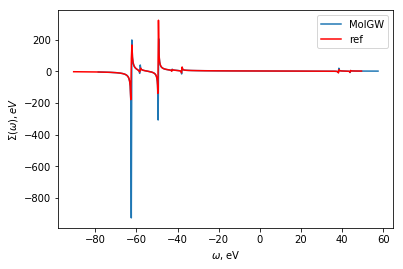

In [35]:
import pandas as pd

def Sigma_on_grid(omega_grid, o):
    
    # The function calculates the real part of 
    # the oo diagonal element of self-energy 
    # on a grid in frequency domain
    
    omega_grid = np.asarray(omega_grid)
    Dis_ = Dis + omega_grid.reshape((-1, 1, 1)) - 2.j*eta
    Das_ = Das + omega_grid.reshape((-1, 1, 1)) + 2.j*eta
    
    # Contribution due to occupied orbitals
    Sigma_c = np.einsum("is, kis, is->k", omega_rts[o,:nocc,:], 1./Dis_, omega_rts[o,:nocc,:])
    # Contribution due to virtuals
    Sigma_c +=  np.einsum("as, kas, as->k", omega_rts[o,nocc:,:], 1./Das_, omega_rts[o,nocc:,:])
    
    return Sigma_c.real

# read reference data from selfenergy file written by MolGW

se = pd.read_table('selfenergy_GW_state005.dat', header=0, sep='\s+')
plt.plot(se['omega'], se['ReSigmaC(eV)'], label='MolGW')

orbital_index = 4 # HOMO
# 10 eV window around HOMO
o_grid = np.linspace(-80./27.21138505, +60./27.21138505, 500) + epsilon[orbital_index]
sigma_o = Sigma_on_grid(o_grid, orbital_index)

plt.plot(o_grid*27.21138505, sigma_o*27.21138505, 'r-', label='ref')
plt.xlabel('$\omega$, eV')
plt.ylabel('$\Sigma(\omega), eV$')

plt.legend()


# TODO

1. Implement graphical solution of the QP equation (same as in MolGW) and identify the source of discrepancy between the qp energies.
2. Resolution of identity calculation of $\omega_{mn}^{s}$ tensors
3. General implementation of GW@DFT (so that it can be used for spin-polarized systems, i.e. UKS reference)
4. Bethe-Salpeter equation for excitation energies